In [1]:
# Load packages

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import cmasher as cmr
import random
from unyt import Msun, yr, Mpc, angstrom
import seaborn as sns
import pandas as pd
import os

from synthesizer.grid import Grid
from synthesizer.load_data.load_scsam import load_SCSAM
from synthesizer.emission_models import (
    BlackHoleEmissionModel,
    GalaxyEmissionModel,
    StellarEmissionModel,
    AttenuatedEmission,
    TotalEmission
)
from synthesizer.particle.galaxy import Galaxy as ParticleGalaxy
from synthesizer.particle.stars import Stars as ParticleStars
from synthesizer.particle import BlackHoles, Gas
from synthesizer.emission_models.attenuation import ParametricLi08

plt.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 14})
    
def get_sfh_data(filename):
    """
    Load an SCSAM sfhist_*.dat file containing one or more galaxies.

    File structure example:
        0.3 0.6711              <-- cosmology (Omega_m, h)
        1405                    <-- number of age bins
        <1405 age bin values>   <-- in Gyr
        # 54 ... 0.227446       <-- start of galaxy block (redshift = 0.227446)
        <1405 lines of "SFH  Z"> per galaxy
         
    Uses 2D NumPy arrays for fast access.

    Returns:
        age_lst   : np.ndarray of age bins (same for all galaxies)
        sfh_arr   : np.ndarray, shape (n_gal, n_age_bins)
        Z_arr     : np.ndarray, shape (n_gal, n_age_bins)
        redshifts : np.ndarray, shape (n_gal,)
    """
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Cosmology & number of age bins
    n_age_bins = int(lines[1].strip())

    # Read age bins
    age_values = []
    line_idx = 2
    while len(age_values) < n_age_bins:
        tokens = lines[line_idx].strip().split()
        age_values.extend(map(float, tokens))
        line_idx += 1
    age_values = np.array(age_values[:n_age_bins])

    # Count galaxies
    n_gal = sum(1 for line in lines if line.startswith("#"))

    # Preallocate arrays
    sfh_arr = np.zeros((n_gal, n_age_bins), dtype=float)
    Z_arr = np.zeros((n_gal, n_age_bins), dtype=float)
    redshifts = np.zeros(n_gal, dtype=float)

    # Read galaxy blocks
    gal_idx = 0
    while line_idx < len(lines):
        line = lines[line_idx].strip()
        if line.startswith("#"):
            redshifts[gal_idx] = float(line.split()[-1])
            for j in range(n_age_bins):
                vals = lines[line_idx + 1 + j].strip().split()
                if len(vals) >= 2:
                    sfh_arr[gal_idx, j] = float(vals[0])
                    Z_arr[gal_idx, j] = float(vals[1])
            line_idx += n_age_bins + 1
            gal_idx += 1
        else:
            line_idx += 1

    return age_values, sfh_arr, Z_arr, redshifts[0]

def get_single_galaxy(SFH, age_lst, Z_hist, z):
    """Create a particle-based galaxy using Synthesizer using the SC-SAM data
    loaded in get_galaxies. We also need the LHS dust parameters."""

    stars = ParticleStars(
        initial_masses=SFH * 1e9 * Msun,
        ages=age_lst * 1e9 * yr,
        metallicities=Z_hist
    )
    gal = ParticleGalaxy(
        redshift=z,
        stars=stars
    )
    return gal

def get_galaxies(sfh_file, galprop_file, N=None):
    """
    Load galaxies using SFH .dat and corresponding galprop .dat for non-SFH properties.
    Returns a list of ParticleGalaxy objects.
    """
    # Load SFH data
    age_lst, sfh_arr, Z_arr, redshift_sfh = get_sfh_data(sfh_file)
    n_gal = sfh_arr.shape[0]

    # Load galprop data
    galprop_cols = [
        "halo_index", "birthhaloid", "roothaloid", "redshift", "sat_type",
        "mhalo", "m_strip", "rhalo", "mstar", "mbulge", "mstar_merge",
        "v_disk", "sigma_bulge", "r_disk", "r_bulge", "mcold", "mHI", "mH2",
        "mHII", "Metal_star", "Metal_cold", "sfr", "sfrave20myr", "sfrave100myr",
        "sfrave1gyr", "mass_outflow_rate", "metal_outflow_rate", "mBH",
        "maccdot", "maccdot_radio", "tmerge", "tmajmerge", "mu_merge",
        "t_sat", "r_fric", "x_position", "y_position", "z_position", "vx", "vy", "vz"
    ]
    df_galprop = pd.read_csv(galprop_file, comment='#', delim_whitespace=True, names=galprop_cols)

    redshifts_prop = df_galprop["redshift"].to_numpy()

    # Find galprop rows with redshifts matching SFH redshift
    # (using a small tolerance for float comparisons)
    tol = 1e-4
    to_galprop = np.where(
        np.isclose(df_galprop["redshift"].to_numpy(), redshift_sfh, atol=tol)
    )[0]
    
    # Safety check
    if len(to_galprop) == 0:
        raise ValueError(f"No matching redshifts found between {sfh_file} and {galprop_file}")
    
    # Extract galprop arrays

    bh_mass = df_galprop["mBH"][to_galprop]
    bh_mdot = df_galprop["maccdot"][to_galprop]

    all_indices = np.arange(n_gal)

   # Determine number of galaxies to load
    all_indices = np.arange(n_gal)
    if N:
        sampled_indices = np.random.choice(all_indices, size=min(N, n_gal), replace=False)
    else:
        sampled_indices = all_indices

    # Build galaxies
    galaxies = [
        get_single_galaxy(sfh_arr[i], age_lst, Z_arr[i], redshifts_prop[i])
        for i in sampled_indices
    ]

    return galaxies


def define_emission_model(UV_slope, FUV_slope, bump, tau_v):
    """Define dust model using loaded grids."""

    stellar_incident = StellarEmissionModel(
        "stellar_incident", grid=grid_sps, extract="incident", fesc=1.0
    )

    # Get LHC dust parameters from galaxy attributes, loaded from LHC file
    li08_curve = ParametricLi08(
        UV_slope=UV_slope,
        OPT_NIR_slope=1.87,
        FUV_slope=FUV_slope,
        bump=bump,
        model='Custom'
    )

    attenuated = AttenuatedEmission(
        emitter="stellar",
        dust_curve=li08_curve,
        tau_v=tau_v,
        apply_to=stellar_incident,
        label="stellar_attenuated",
    )

    return attenuated

sam_dir = '/mnt/ceph/users/lperez/AGNmodelingSCSAM/sam_newAGNcode_multizs_Sophie'
grid_dir = '/mnt/ceph/users/snewman/grids'
grid_name = 'qsosed.hdf5'
grid_sps_name = 'bpass-2.2.1-bin_bpl-0.1,1.0,300.0-1.3,2.35.hdf5'

# Define a single, desired output wavelength array (e.g., 10000 points from 10 A to 1,000,000 A)
desired_lams = np.logspace(0.1, 6, 10000) * angstrom

# Load grids
grid_agn = Grid(grid_dir=grid_dir, grid_name=grid_name, ignore_lines=True, new_lam=desired_lams)
grid_sps = Grid(grid_dir=grid_dir, grid_name=grid_sps_name, ignore_lines=True, new_lam=desired_lams)


/mnt/home/snewman/myenv/lib/python3.12/site-packages/spectres/spectral_resampling.py:104: RuntimeWarning: Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument (by default 0).
  warnings.warn(


In [2]:
# --- Define subvolumes ---
subvolumes = [
    "0_0_0", "0_0_1", "0_1_0", "0_1_1",
    "1_0_0", "1_0_1", "1_1_0", "1_1_1"
]

# Number of galaxies to load
N = None

snap = 67

# Load galaxies (SFH + galprop)
gals_all = []
for subvol in subvolumes:
    gals_sub = get_galaxies(
        sfh_file=f"{sam_dir}/{subvol}/sfhist_{snap}-{snap}.dat",   # replace with your file
        galprop_file=f"{sam_dir}/{subvol}/galprop_{snap}-{snap}.dat",
        N=N  
    )
    gals_all.append(gals_sub)

gals_all = np.concatenate(gals_all)
n_gal_total = len(gals_all)
print(f"Total galaxies loaded: {n_gal_total}")

/tmp/ipykernel_1914788/1986494126.py:126: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_galprop = pd.read_csv(galprop_file, comment='#', delim_whitespace=True, names=galprop_cols)
/tmp/ipykernel_1914788/1986494126.py:101: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to
`None`
  gal = ParticleGalaxy(
/tmp/ipykernel_1914788/1986494126.py:126: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_galprop = pd.read_csv(galprop_file, comment='#', delim_whitespace=True, names=galprop_cols)
/tmp/ipykernel_1914788/1986494126.py:101: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to
`None`
  gal = ParticleGalaxy(
/tmp/ipykernel_1914788/1986494126.py:126: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprec

Total galaxies loaded: 98623


In [36]:
# --- Define galprop column names ---
galprop_cols = [
    "halo_index", "birthhaloid", "roothaloid", "redshift", "sat_type",
    "mhalo", "m_strip", "rhalo", "mstar", "mbulge", "mstar_merge",
    "v_disk", "sigma_bulge", "r_disk", "r_bulge", "mcold", "mHI", "mH2",
    "mHII", "Metal_star", "Metal_cold", "sfr", "sfrave20myr", "sfrave100myr",
    "sfrave1gyr", "mass_outflow_rate", "metal_outflow_rate", "mBH",
    "maccdot", "maccdot_radio", "tmerge", "tmajmerge", "mu_merge",
    "t_sat", "r_fric", "x_position", "y_position", "z_position", "vx", "vy", "vz"
]

# --- Prepare empty lists to combine data from all subvolumes ---
all_stellar_mass = []
all_metal_mass = []
all_disk_radius = []
all_Av_values = []
all_halo_mass = []

# --- Loop through all subvolumes ---
for subvol in subvolumes:
    galprop_file = os.path.join(sam_dir, subvol, "galprop_11-11.dat")
    
    # Load galprop data
    df_galprop = pd.read_csv(galprop_file, comment='#', delim_whitespace=True, names=galprop_cols)
    
    # Extract physical quantities
    stellar_mass = df_galprop["mstar"].to_numpy() * 1e9        # in Msun
    metal_mass = df_galprop["Metal_cold"].to_numpy() * 1e9     # in Msun
    disk_radius = df_galprop["r_disk"].to_numpy()              # in kpc
    halo_mass = df_galprop["mhalo"].to_numpy() * 1e9

    # Compute A_v values
    indices = np.arange(len(disk_radius))
    cosine_incs = np.random.uniform(0.2, 0.98, len(disk_radius))
    k_v = 3.4822e4  # cm^2/g
    
    A_v_values = 4.4e-3 * (1 / cosine_incs) * k_v * (metal_mass / 1e10) * (disk_radius ** -2)
    
    # Combine results across all subvolumes
    all_stellar_mass.append(stellar_mass)
    all_metal_mass.append(metal_mass)
    all_disk_radius.append(disk_radius)
    all_Av_values.append(A_v_values)
    all_halo_mass.append(halo_mass)

# --- Concatenate into single arrays ---
all_stellar_mass = np.concatenate(all_stellar_mass)
all_metal_mass = np.concatenate(all_metal_mass)
all_disk_radius = np.concatenate(all_disk_radius)
all_Av_values = np.concatenate(all_Av_values)
all_halo_mass = np.concatenate(all_halo_mass)

# --- Done ---
print(f"Combined arrays shapes:")
print(f"stellar_mass: {all_stellar_mass.shape}")
print(f"metal_mass:   {all_metal_mass.shape}")
print(f"disk_radius:  {all_disk_radius.shape}")
print(f"A_v_values:   {all_Av_values.shape}")



# Get emission model
"""
# Define other emission model parameters
UV_slope = 44.9
FUV_slope = 61.2
bump = 0.03
A_V = 1.086 * tau_V
model = define_emission_model(UV_slope=UV_slope, 
                                FUV_slope=FUV_slope, 
                                bump=bump, 
                                tau_v=A_v)

gal.get_spectra(model)
spectra_type = "stellar_attenuated" 
sed = gal.stars.spectra[spectra_type]
seds.append((sed.lam, sed.lnu))
"""

Combined arrays shapes:
stellar_mass: (13788,)
metal_mass:   (13788,)
disk_radius:  (13788,)
A_v_values:   (13788,)


/tmp/ipykernel_1914788/488092467.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_galprop = pd.read_csv(galprop_file, comment='#', delim_whitespace=True, names=galprop_cols)
/tmp/ipykernel_1914788/488092467.py:37: RuntimeWarning: divide by zero encountered in power
  A_v_values = 4.4e-3 * (1 / cosine_incs) * k_v * (metal_mass / 1e10) * (disk_radius ** -2)
/tmp/ipykernel_1914788/488092467.py:37: RuntimeWarning: invalid value encountered in multiply
  A_v_values = 4.4e-3 * (1 / cosine_incs) * k_v * (metal_mass / 1e10) * (disk_radius ** -2)
/tmp/ipykernel_1914788/488092467.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_galprop = pd.read_csv(galprop_file, comment='#', delim_whitespace=True, names=galprop_cols)
/tmp/ipykernel_1914788/488092467.py:37: RuntimeWarning: divide by zero e

'\n# Define other emission model parameters\nUV_slope = 44.9\nFUV_slope = 61.2\nbump = 0.03\nA_V = 1.086 * tau_V\nmodel = define_emission_model(UV_slope=UV_slope, \n                                FUV_slope=FUV_slope, \n                                bump=bump, \n                                tau_v=A_v)\n\ngal.get_spectra(model)\nspectra_type = "stellar_attenuated" \nsed = gal.stars.spectra[spectra_type]\nseds.append((sed.lam, sed.lnu))\n'

In [ ]:
# Load Salim18 data from file
salim_data = pd.read_csv(
    '/mnt/home/snewman/ceph/Salim18_data_for_laura_dis.txt',
    delim_whitespace=True,
    comment='#'   # optional, if there are comment lines
)

# Extract arrays for log_mstar and r_eff and ensure they are floats
log_mstar_salim = salim_data.iloc[:, 4].to_numpy(dtype=float)
r_eff_salim = salim_data.iloc[:, 9].to_numpy(dtype=float)
A_v_salim = salim_data.iloc[:, 10].to_numpy(dtype=float)

0.000608246514437935
11361611.602906259


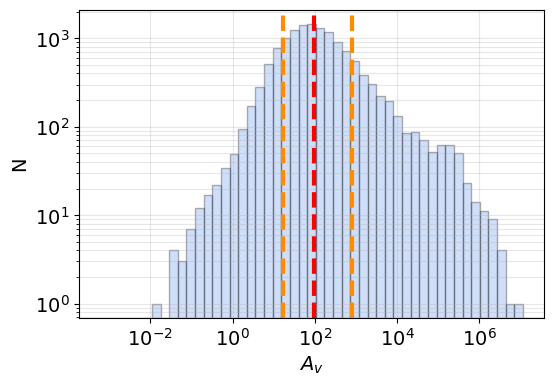

0.0
3.67777


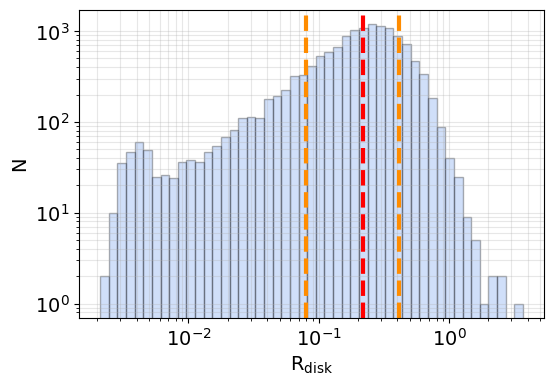

[3.56977e+08 3.35975e+08 1.78890e+07 ... 9.21430e+08 1.59329e+08
 1.90895e+08]


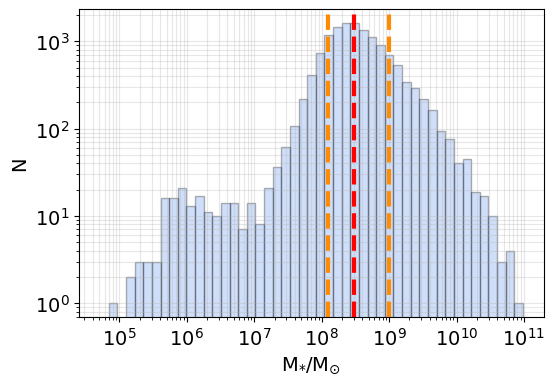

In [32]:
print(min(all_Av_values))
print(max(all_Av_values))
mask = all_Av_values > 0

# Plot histogram of A_v values 

median = np.median(all_Av_values[mask])
p16, p84 = np.percentile(all_Av_values[mask], [16, 84])

n_bins = 50
log_min = np.log10(all_Av_values[mask].min())
log_max = np.log10(all_Av_values[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

plt.figure(figsize=(6, 4))
plt.hist(all_Av_values[mask], bins=bins, color='cornflowerblue', edgecolor='black', alpha=0.3)
plt.xlabel(r"$A_v$")
plt.ylabel("N")
plt.yscale('log')
plt.xscale('log')
plt.grid(alpha=0.3, which='both')  # grid for both major/minor ticks

plt.axvline(median, color='red', linestyle='--', linewidth=3, label='Median')
plt.axvline(p16, color='darkorange', linestyle='--', linewidth=3, label='16th & 84th percentiles')
plt.axvline(p84, color='darkorange', linestyle='--', linewidth=3)

plt.show()

# Plot histogram of uncorrected r_disk values

print(min(all_disk_radius))
print(max(all_disk_radius))
mask = all_disk_radius > 0

median = np.median(all_disk_radius[mask])
p16, p84 = np.percentile(all_disk_radius[mask], [16, 84])

n_bins = 50
log_min = np.log10(all_disk_radius[mask].min())
log_max = np.log10(all_disk_radius[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

plt.figure(figsize=(6, 4))
plt.hist(all_disk_radius[mask], bins=bins, color='cornflowerblue', edgecolor='black', alpha=0.3)
plt.xlabel(r"$\rm R_{disk}$")
plt.ylabel("N")
plt.yscale('log')
plt.xscale('log')
plt.grid(alpha=0.3, which='both')  # grid for both major/minor ticks

plt.axvline(median, color='red', linestyle='--', linewidth=3, label='Median')
plt.axvline(p16, color='darkorange', linestyle='--', linewidth=3, label='16th & 84th percentiles')
plt.axvline(p84, color='darkorange', linestyle='--', linewidth=3)

plt.show()

# Plot histogram of stellar masses

# Plot histogram of A_v values 

print(all_stellar_mass)

mask = all_stellar_mass > 0

median = np.median(all_stellar_mass[mask])
p16, p84 = np.percentile(all_stellar_mass[mask], [16, 84])

n_bins = 50
log_min = np.log10(all_stellar_mass[mask].min())
log_max = np.log10(all_stellar_mass[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

plt.figure(figsize=(6, 4))
plt.hist(all_stellar_mass[mask], bins=bins, color='cornflowerblue', edgecolor='black', alpha=0.3)
plt.xlabel(r"$\rm M_{*}/M_{\odot}$")
plt.ylabel("N")
plt.yscale('log')
plt.xscale('log')
plt.grid(alpha=0.3, which='both')  # grid for both major/minor ticks

plt.axvline(median, color='red', linestyle='--', linewidth=3, label='Median')
plt.axvline(p16, color='darkorange', linestyle='--', linewidth=3, label='16th & 84th percentiles')
plt.axvline(p84, color='darkorange', linestyle='--', linewidth=3)

plt.show()



/tmp/ipykernel_1914788/1222915572.py:44: RuntimeWarning: divide by zero encountered in log10
  plt.plot(M_centers, np.log10(phi), 'ko-', lw=2, label='SAM')


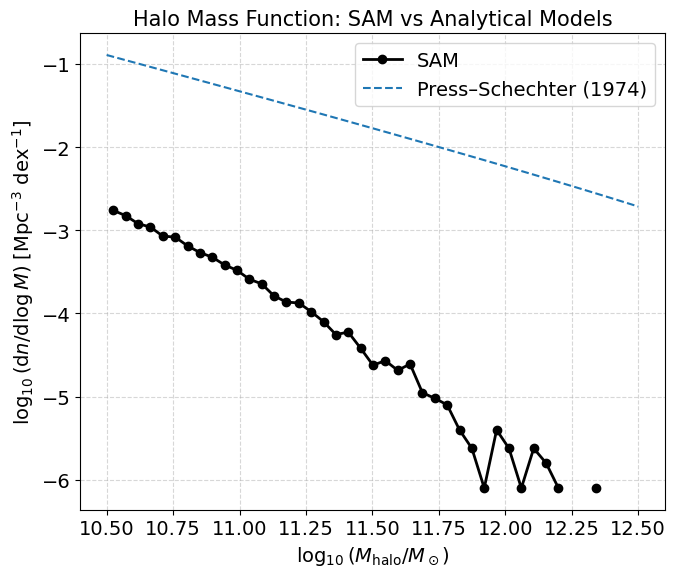

In [31]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function

# --- Define your SAM cosmology ---
cosmo_dict = {
    'flat': True,
    'H0': 70.0,        # km/s/Mpc
    'Om0': 0.3,
    'Ob0': 0.048,
    'sigma8': 0.8,
    'ns': 0.96
}
cosmology.addCosmology('myCosmo', cosmo_dict)
cosmo = cosmology.setCosmology('myCosmo')

# --- Bin the data ---
nbins = 40
logM = np.log10(all_halo_mass)
M_bins = np.linspace(logM.min(), logM.max(), nbins + 1)
M_centers = 0.5 * (M_bins[1:] + M_bins[:-1])

# --- Count halos per bin ---
counts, _ = np.histogram(logM, bins=M_bins)

# --- Compute differential number density ---
V_sub = (150)**3   # e.g., each subvolume is 150 Mpc/h on a side
V_total = V_sub * len(subvolumes)

# dN/dlogM = N / (V * ΔlogM)
dlogM = M_bins[1] - M_bins[0]
phi = counts / (V_total * dlogM)

# --- Analytical HMFs from Colossus ---
M_theory = np.logspace(10.5, 12.5, 100)

# Redshift (can change to match your SAM snapshot)
z = 0.46

phi_ps = mass_function.massFunction(M_theory, z=z, mdef='fof',
                                    model='press74', q_out='dndlnM')

# --- Plot ---
plt.figure(figsize=(7,6))
plt.plot(M_centers, np.log10(phi), 'ko-', lw=2, label='SAM')
plt.plot(np.log10(M_theory), np.log10(phi_ps), '--', label='Press–Schechter (1974)')

plt.xlabel(r'$\log_{10}(M_{\mathrm{halo}}/M_\odot)$', fontsize=14)
plt.ylabel(r'$\log_{10}(\mathrm{d}n/\mathrm{d}\log M)\ [\mathrm{Mpc}^{-3}\ \mathrm{dex}^{-1}]$', fontsize=14)
plt.title("Halo Mass Function: SAM vs Analytical Models", fontsize=15)
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
#plt.ylim(top=-2.5,bottom=-6.5)
plt.show()

4.713786971794906 10.98463576091141
[ 4.71378697  4.87055819  5.02732941  5.18410063  5.34087185  5.49764307
  5.65441429  5.81118551  5.96795673  6.12472795  6.28149917  6.43827039
  6.59504161  6.75181283  6.90858405  7.06535527  7.22212649  7.37889771
  7.53566893  7.69244015  7.84921137  8.00598259  8.16275381  8.31952503
  8.47629625  8.63306746  8.78983868  8.9466099   9.10338112  9.26015234
  9.41692356  9.57369478  9.730466    9.88723722 10.04400844 10.20077966
 10.35755088 10.5143221  10.67109332 10.82786454 10.98463576]


/tmp/ipykernel_1914788/1216425821.py:23: RuntimeWarning: divide by zero encountered in log10
  plt.plot(M_centers, np.log10(phi), '-', lw=2, label='SAM')


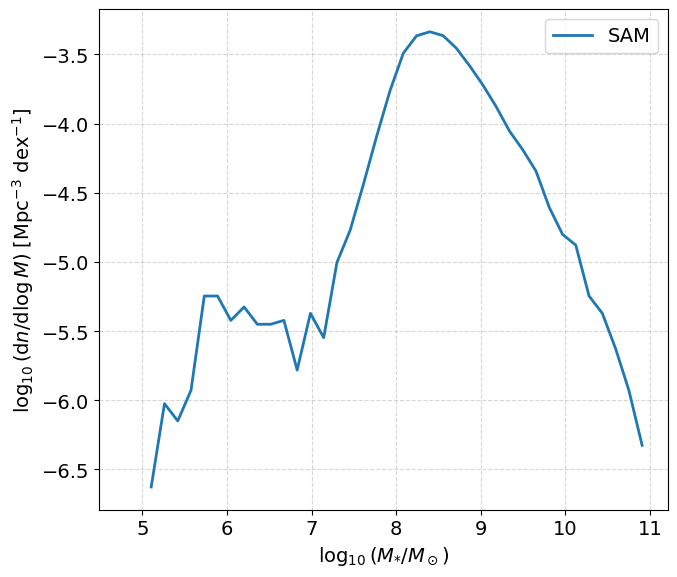

In [41]:
# --- Bin the data ---
mask = all_stellar_mass > 0
nbins = 40
logM = np.log10(all_stellar_mass[mask])
print(min(logM), max(logM))
M_bins = np.linspace(logM.min(), logM.max(), nbins + 1)
print(M_bins)
M_centers = 0.5 * (M_bins[1:] + M_bins[:-1])

# --- Count halos per bin ---
counts, _ = np.histogram(logM, bins=M_bins)

# --- Compute differential number density ---
V_sub = (150)**3   # e.g., each subvolume is 150 Mpc/h on a side
V_total = V_sub * len(subvolumes)

# dN/dlogM = N / (V * ΔlogM)
dlogM = M_bins[1] - M_bins[0]
phi = counts / (V_total * dlogM)

# --- Plot ---
plt.figure(figsize=(7,6))
plt.plot(M_centers, np.log10(phi), '-', lw=2, label='SAM')
plt.xlabel(r'$\log_{10}(M_{\mathrm{*}}/M_\odot)$', fontsize=14)
plt.ylabel(r'$\log_{10}(\mathrm{d}n/\mathrm{d}\log M)\ [\mathrm{Mpc}^{-3}\ \mathrm{dex}^{-1}]$', fontsize=14)
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate corrected Av values

all_cosine_incs  = np.random.uniform(0.2, 0.98, len(all_disk_radius))

k_v = 3.4822e4  # cm^2/g
#mask_valid = (all_stellar_mass > 0) & (all_metal_mass > 0) & (all_disk_radius > 0)
A_v_sim = np.full_like(all_stellar_mass, np.nan)
A_v_sim = (
    4.4e-3 * (1 / all_cosine_incs) * k_v *
    (all_metal_mass / 1e10) * (all_disk_radius ** -2)
)

# --- Compute global correction factor ---
median_Av_sim = np.nanmedian(A_v_sim)
median_Av_obs = np.nanmedian(A_v_salim)

print('Median Av for obs:', median_Av_obs)

# A_v ∝ R^-2 ⇒ R_corr = R * (A_v_sim / A_v_obs)^(1/2)
f_global = np.sqrt(median_Av_sim / median_Av_obs)
print(f"Global gas radius correction factor: {f_global:.3f}")

#f_global = 800

# Apply correction
disk_radius_corrected = all_disk_radius * f_global
A_v_corrected = (
    4.4e-3 * (1 / all_cosine_incs) * k_v *
    (all_metal_mass / 1e10) * (disk_radius_corrected ** -2)
)

print('Median Av for sim:', np.nanmedian(A_v_corrected))
print('N Av corrected', len(A_v_corrected))

# --- Compare before and after ---
plt.figure(figsize=(6,6))
#plt.scatter(np.log10(stellar_mass), A_v_sim, color="gray", alpha=0.4, label="Simulated (uncorrected)")
plt.scatter(log_mstar_salim, A_v_salim, color="red", alpha=0.6, label="Observed (Salim18)")
plt.scatter(np.log10(all_stellar_mass), A_v_corrected, color="blue", alpha=0.6, label="Simulated (corrected)")
plt.xlabel(r"$\log(M_*/M_\odot)$")
plt.ylabel(r"$A_V$")
plt.ylim(0, 2)
plt.legend()
plt.show()

# Plot A_v vs Mstar

# Create figure + axis
fig, ax = plt.subplots(figsize=(6, 6))

mask = A_v_corrected < 2

# Plot first dataset (kde background)
sns.kdeplot(
    x=np.log10(all_stellar_mass[mask]),
    y=A_v_corrected[mask],
    fill=True,
    cmap="rocket_r",
    alpha=0.6,
    ax=ax,
    label="Main sample"
)

# Plot second dataset (Salim18)
sns.kdeplot(
    x=log_mstar_salim[A_v_salim > 0],
    y=A_v_salim[A_v_salim > 0],
    fill=True,
    cmap="mako_r",
    alpha=0.6,
    ax=ax,
    label="Salim18 sample"
)

# Add labels and legend

# Custom legend patches
main_patch = mpatches.Patch(color=sns.color_palette("rocket_r", as_cmap=True)(0.6), label="SAM sample")
salim_patch = mpatches.Patch(color=sns.color_palette("mako_r", as_cmap=True)(0.6), label="Salim18 sample")

ax.legend(handles=[main_patch, salim_patch], loc='upper right')

plt.xlabel(r"$\rm log(M_*/M_\odot)$")
plt.ylabel(r"$A_v$")
plt.ylim(top=2, bottom=0)
plt.show()


In [ ]:
mask = A_v_corrected < 100

print(len(A_v_corrected > 100))

# --- Create figure layout with marginals ---
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(7, 7))
gs = GridSpec(4, 4, figure=fig, hspace=0.05, wspace=0.05)

ax_main = fig.add_subplot(gs[1:, :-1])  # main KDE plot
ax_xhist = fig.add_subplot(gs[0, :-1], sharex=ax_main)  # top histogram
ax_yhist = fig.add_subplot(gs[1:, -1], sharey=ax_main)  # right histogram

# --- Main KDE plots ---
sns.kdeplot(
    x=np.log10(all_stellar_mass[mask]),
    y=A_v_corrected[mask],
    fill=True, cmap="rocket_r", alpha=0.6,
    ax=ax_main
)

sns.kdeplot(
    x=log_mstar_salim[A_v_salim > 0],
    y=A_v_salim[A_v_salim > 0],
    fill=True, cmap="mako_r", alpha=0.6,
    ax=ax_main
)

# --- Marginal histograms ---
bins_x = np.linspace(
    min(np.log10(all_stellar_mass[mask]).min(), log_mstar_salim[A_v_salim > 0].min()),
    max(np.log10(all_stellar_mass[mask]).max(), log_mstar_salim[A_v_salim > 0].max()),
    30
)
bins_y = np.linspace(0, 2, 30)

ax_xhist.hist(np.log10(all_stellar_mass[mask]), bins=bins_x, color=sns.color_palette("rocket_r")[3], alpha=0.6)
ax_xhist.hist(log_mstar_salim[A_v_salim > 0], bins=bins_x, color=sns.color_palette("mako_r")[3], alpha=0.6)

ax_yhist.hist(A_v_corrected[mask], bins=bins_y, orientation='horizontal', color=sns.color_palette("rocket_r")[3], alpha=0.6)
ax_yhist.hist(A_v_salim[A_v_salim > 0], bins=bins_y, orientation='horizontal', color=sns.color_palette("mako_r")[3], alpha=0.6)

# --- Clean up axis appearance ---
ax_xhist.axis('off')
ax_yhist.axis('off')

# Labels and limits
ax_main.set_xlabel(r"$\log(M_*/M_\odot)$")
ax_main.set_ylabel(r"$A_V$")
ax_main.set_ylim(0, 2)

# Legend
main_patch = mpatches.Patch(color=sns.color_palette("rocket_r")[3], label="SAM sample")
salim_patch = mpatches.Patch(color=sns.color_palette("mako_r")[3], label="Salim18 sample")
ax_main.legend(handles=[main_patch, salim_patch], loc='upper right')

print(len(A_v_corrected[mask]))
print(len(A_v_salim[A_v_salim > 0]))

plt.show()

In [ ]:
print(min(A_v_corrected))
print(max(A_v_corrected))

# Plot histogram of A_v values 

mask = A_v_corrected > 0

median = np.median(A_v_corrected[mask])
p16, p84 = np.percentile(A_v_corrected[mask], [16, 84])

n_bins = 50
log_min = np.log10(A_v_corrected[mask].min())
log_max = np.log10(A_v_corrected[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

plt.figure(figsize=(6, 4))
plt.hist(A_v_corrected[mask], bins=bins, color='cornflowerblue', edgecolor='black', alpha=0.3)
plt.xlabel(r"$A_v$ with corrected $\rm r_{disk}$")
plt.ylabel("N")
plt.yscale('log')
plt.xscale('log')
plt.grid(alpha=0.3, which='both')  # grid for both major/minor ticks

plt.axvline(median, color='red', linestyle='--', linewidth=3, label='Median')
plt.axvline(p16, color='darkorange', linestyle='--', linewidth=3, label='16th & 84th percentiles')
plt.axvline(p84, color='darkorange', linestyle='--', linewidth=3)

plt.show()

# Plot histogram of corrected r_disk values

print(min(disk_radius_corrected))
print(max(disk_radius_corrected))
mask = disk_radius_corrected > 0

median = np.median(disk_radius_corrected[mask])
p16, p84 = np.percentile(disk_radius_corrected[mask], [16, 84])

print('Median rdisk:', median)

n_bins = 50
log_min = np.log10(disk_radius_corrected[mask].min())
log_max = np.log10(disk_radius_corrected[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

plt.figure(figsize=(6, 4))
plt.hist(disk_radius_corrected[mask], bins=bins, color='cornflowerblue', edgecolor='black', alpha=0.3)
plt.xlabel(r"b (=20) $\rm \cdot R_{disk}$")
plt.ylabel("N")
plt.yscale('log')
plt.xscale('log')
plt.grid(alpha=0.3, which='both')  # grid for both major/minor ticks

plt.axvline(median, color='red', linestyle='--', linewidth=3, label='Median')
plt.axvline(p16, color='darkorange', linestyle='--', linewidth=3, label='16th & 84th percentiles')
plt.axvline(p84, color='darkorange', linestyle='--', linewidth=3)

plt.show()

In [ ]:
# Get spectra using corrected Av values:

print(len(all_disk_radius))
print(len(A_v_corrected))

to_galprop = 

for gal_idx, gal in enumerate(gals_all) : 

    # Get emission model

    A_v = A_v_corrected[to_galprop][gal_idx]

    tau_v = A_v / 1.086

    # Define other emission model parameters
    UV_slope = 44.9
    FUV_slope = 61.2
    bump = 0.03
    
    model = define_emission_model(UV_slope=UV_slope, 
                                    FUV_slope=FUV_slope, 
                                    bump=bump, 
                                    tau_v=tau_v)

    gal.get_spectra(model)
    spectra_type = "stellar_attenuated" 
    sed = gal.stars.spectra[spectra_type]
    seds.append((sed.lam, sed.lnu))

In [ ]:
# Plot the SEDs with dust attenuation

# Choose a cmasher colormap, e.g., "cmr.rainforest"
cmap = cmr.get_sub_cmap("cmr.bubblegum", 0.05, 0.95)  # full range of the colormap

# Particle SEDs plotting
plt.figure(figsize=(8, 5))

for lam, lnu in seds:
    color = cmap(np.random.rand())  # pick a random color from the colormap
    plt.plot(np.log10(lam), np.log10(lnu), color=color, lw=2)

plt.xlabel(r"$\log_{10}(\lambda/\rm{\AA})$")
plt.ylabel(r"$\log_{10}(L_\nu/\rm{erg\,s^{-1}\,Hz^{-1}})$")
plt.xlim(left=2, right=5)
plt.ylim(bottom=0)
plt.grid(color="whitesmoke")
plt.show()